## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn_image as isns
import seaborn as sns
import scipy.signal as signal
from scipy import stats

import statsmodels.stats.multitest as smm

from sonar import sonar, utils
import math

from distinctipy import distinctipy

from matplotlib.backends.backend_pdf import PdfPages

# Upload sample, define labels

In [3]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
'Endothelial'
]

In [62]:
relevant_cluster_labels =  [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
]

In [5]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


In [6]:
sample_list = []
for sample in range(1,5):
    n_sample = sample

    tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]
    # Islet stack
    rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
    # rescaled_splitted = np.split(rescaled, 16)
    # islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])
    sample_list.append(rescaled)


Text(0.5, 1.0, 'Sample4, scaling = 0.3')

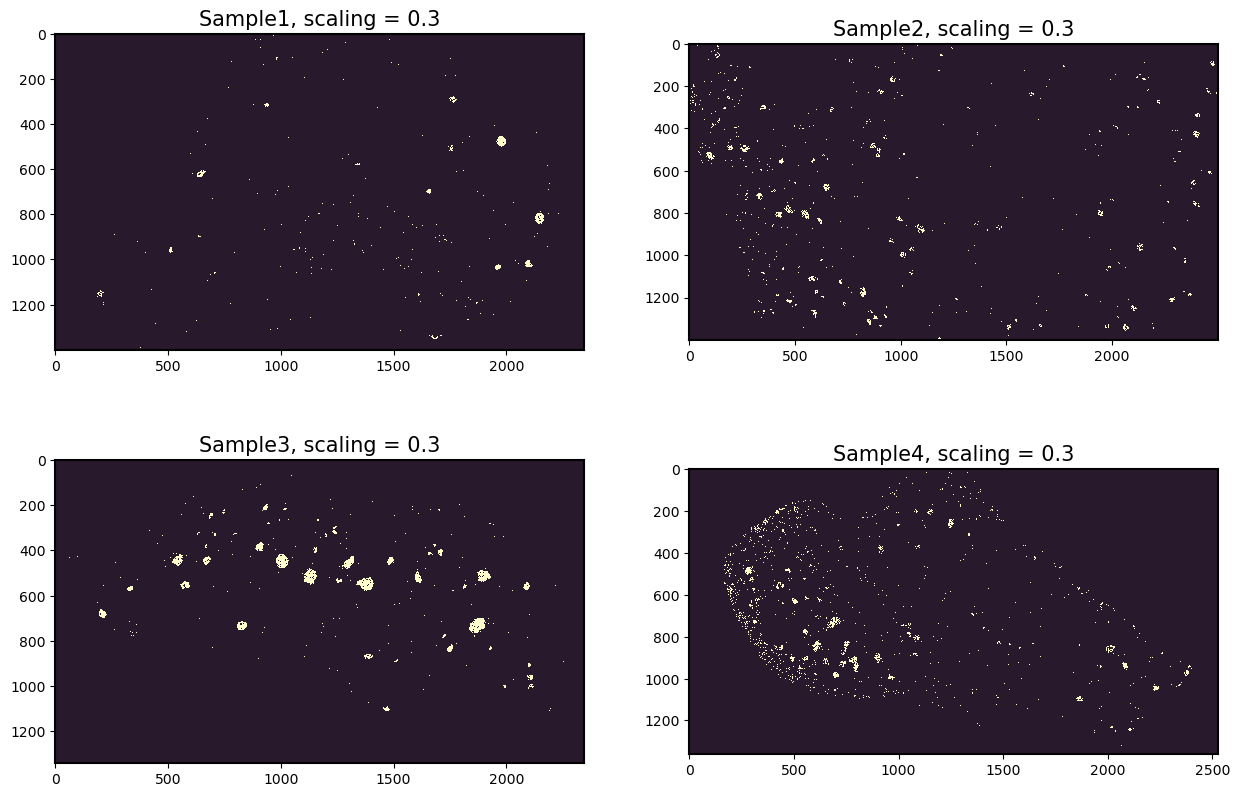

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(sample_list[0][0][200:1600,:])
plt.title("Sample1, scaling = 0.3")

plt.subplot(2,2,2)
plt.imshow(sample_list[1][0][350:1750,500:3000])
plt.title("Sample2, scaling = 0.3")

plt.subplot(2,2,3)
plt.imshow(sample_list[2][0].T)
plt.title("Sample3, scaling = 0.3")

plt.subplot(2,2,4)
plt.imshow(sample_list[3][0][200:,:])
plt.title("Sample4, scaling = 0.3")

In [34]:
rescaled = sample_list[0] # selecting sample

# Sonar run

In [35]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

In [59]:
son = sonar.Sonar(max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)
cooc_template_  = son.co_occurrence_from_tensor(rescaled[1:],interpolate="linear", area_normalization = False) 

In [60]:
cooc_template_.shape

(15, 15, 500)

# Correction to the cell counts in the sample

In [63]:
# calculation of the tissue area of each cell-type
def total_pixel_counts(original_img = rescaled, cell_type_labels = relevant_cluster_labels):

    tissue_pixels = []
    for i in range(1,len(cell_type_labels)+1):
        pix_agreg = np.sum(rescaled[i]) # rescaled[i+1] because under 0 here is a background
        tissue_pixels.append(pix_agreg)

    return list(tissue_pixels)

pixel_counts = total_pixel_counts(rescaled)

In [65]:
# calculation of ratio of cells that are present in the sample

cell_type_proportions = []

total_n = sum(pixel_counts)

for cell_type_counts in pixel_counts:
    ratio = (cell_type_counts)/total_n
    ratio = round(ratio,5)
    cell_type_proportions.append(ratio)

print(cell_type_proportions)


[0.08869, 0.80838, 0.00477, 0.00438, 0.00511, 0.00255, 0.00914, 0.00063, 0.00029, 0.06517, 0.00945, 0.00118, 0.00026, 0.0, 0.0]


In [66]:
len(relevant_cluster_labels)

15

In [67]:
len(cell_type_proportions)

15

In [68]:
pixel_counts_dict_persantage = dict(zip(relevant_cluster_labels, cell_type_proportions))

In [145]:
pixel_counts_dict = dict(zip(relevant_cluster_labels, pixel_counts))
pixel_counts_dict

{'Acinar-i': 76427.0,
 'Acinar-s': 696597.0,
 'Acinar-REG+': 4112.0,
 'Activated Stellate': 3774.0,
 'Quiescent Stellate': 4405.0,
 'Alpha': 2195.0,
 'Beta': 7873.0,
 'Gamma (PP)': 547.0,
 'Delta': 249.0,
 'Ductal': 56161.0,
 'MUC5B+ Ductal (PDG)': 8143.0,
 'MHC Class II': 1017.0,
 'Schwan': 222.0,
 'B cell': 0.0,
 'T cell': 0.0}

In [69]:
pixel_counts_dict_persantage

{'Acinar-i': 0.08869,
 'Acinar-s': 0.80838,
 'Acinar-REG+': 0.00477,
 'Activated Stellate': 0.00438,
 'Quiescent Stellate': 0.00511,
 'Alpha': 0.00255,
 'Beta': 0.00914,
 'Gamma (PP)': 0.00063,
 'Delta': 0.00029,
 'Ductal': 0.06517,
 'MUC5B+ Ductal (PDG)': 0.00945,
 'MHC Class II': 0.00118,
 'Schwan': 0.00026,
 'B cell': 0.0,
 'T cell': 0.0}

# Filtering out zeros

In [154]:
empty_cell_type_map = [index for index, value in enumerate(pixel_counts_dict_persantage.values()) if value == 0]

print("Indices of values below 0.05:", empty_cell_type_map) 

Indices of values below 0.05: [13, 14]


In [161]:
cooc_template_filtered_from_zeros =np.delete(cooc_template_, empty_cell_type_map, axis=0)
cooc_template_filtered_from_zeros =np.delete(cooc_template_filtered_from_zeros, empty_cell_type_map, axis=1)

In [162]:
cooc_template_filtered_from_zeros.shape

(13, 13, 500)

# Normalization

In [165]:

# Normalisation to the number of pixels of cell-types in the tissue

def normalize_co_occurrence_matrix(tensor = cooc_template_filtered_from_zeros, cell_counts = pixel_counts):
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / (cell_counts[j]*cell_type_proportions[i])
    
    return normalized_coocur


normalized_coocur = normalize_co_occurrence_matrix(cooc_template_filtered_from_zeros)

In [166]:
normalized_coocur.shape

(13, 13, 500)

# Filtering out low abundant cells from the report

In [167]:
indices_above_threshold = [index for index, value in enumerate(pixel_counts_dict_persantage.values()) if value > 0.0005]

print("Indices of values below 0.05:", indices_above_threshold) # those are being reported on plots

Indices of values below 0.05: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]


In [48]:
# # preserved colors
# colors = [(0.04539659990856526, 0.9950834146451918, 0.1499488663005254),
#  (1.0, 0.0, 1.0),
#  (0.0, 0.5, 1.0),
#  (1.0, 0.5, 0.0),
#  (0.5, 0.25, 0.5),
#  (0.3806287930848872, 0.9587938095125506, 0.7309407555134216),
#  (0.765350367801373, 0.9841022759439689, 0.05801173998599107),
#  (0.9214116218515722, 0.5101069244842528, 0.8965838031677331),
#  (0.20848553008387116, 0.012218971422101932, 0.9672051864008775),
#  (1.0, 0.0, 0.0),
#  (0.0, 0.5, 0.0),
#  (0.0, 0.5, 0.5),
#  (0.3379250810420038, 0.0247771750361111, 0.6305114722526198),
#  ]

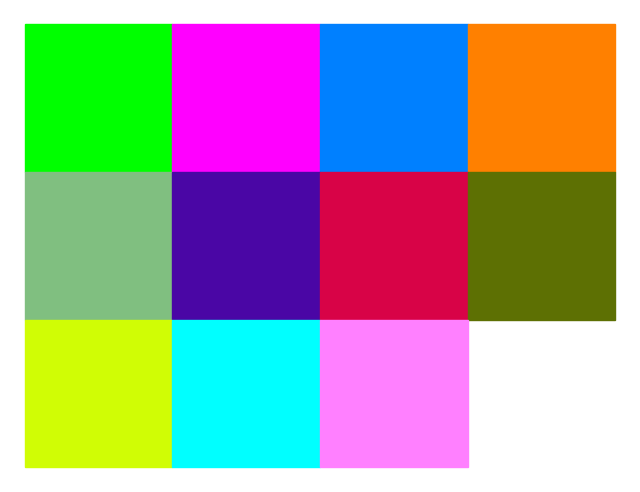

In [134]:
from distinctipy import distinctipy

# number of colours to generate
N = len(indices_above_threshold)

# generate N visually distinct colours
colors = distinctipy.get_colors(N)

# display the colours
distinctipy.color_swatch(colors)

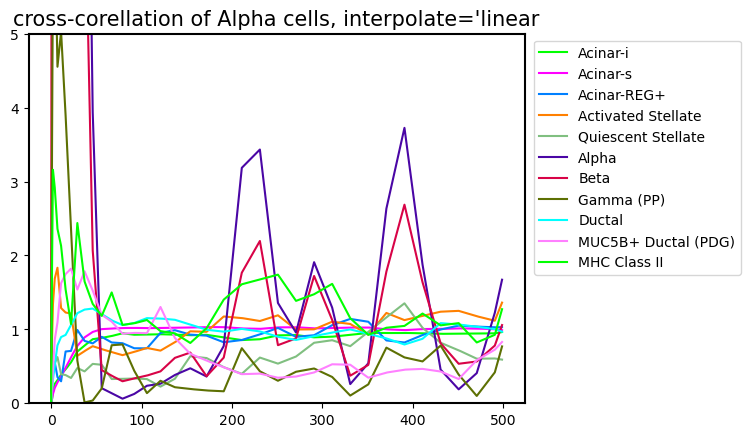

In [168]:
    
for target_cell_type in indices_above_threshold:

    plt.plot(normalized_coocur[5,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
    plt.title("cross-corellation of Alpha cells, interpolate='linear")
    plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1))

plt.ylim(-0,5)
plt.show()

In [116]:
# def compute_bbox_anchor(n_axes, x_ratio=34, y_ratio=30):
#     # Scale the x and y ratios based on the number of axes
#     scaled_x = x_ratio / n_axes
#     scaled_y = y_ratio / n_axes
#     return (scaled_x, scaled_y)

/tmp/ipykernel_1522821/1668378835.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


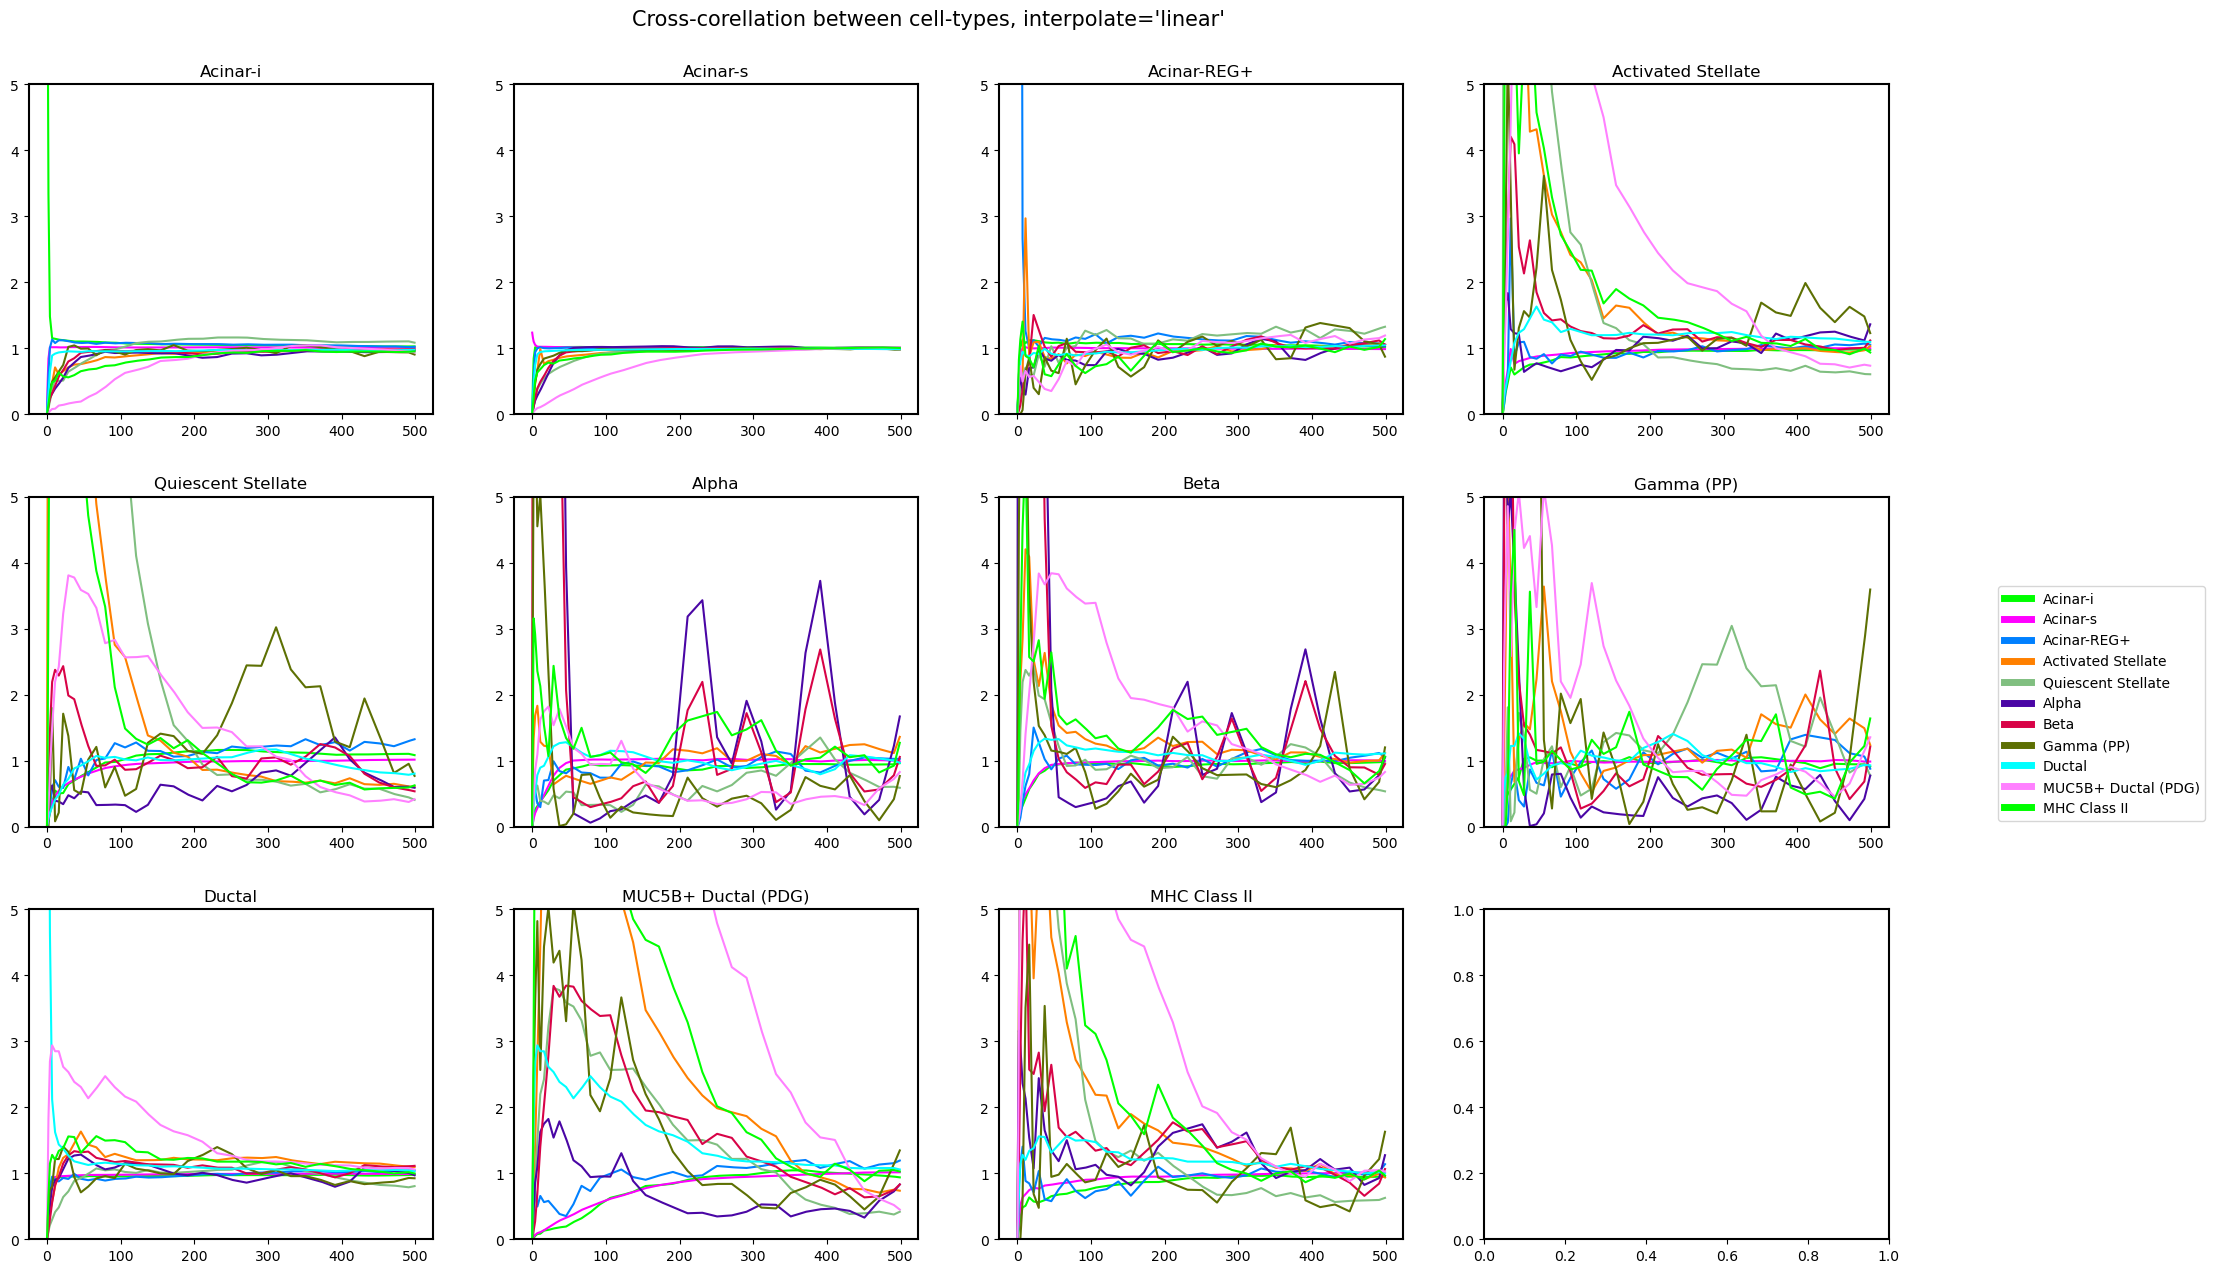

In [169]:
total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 15), gridspec_kw={'hspace': 0.25})

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

    y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2

    for target_cell_type in indices_above_threshold:

        ax.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
        ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}",  fontsize=12)
        ax.set_ylim(0, 5)
    
ax.legend(loc="upper right", bbox_to_anchor=(3,2))

# Adjust the linewidth of legend lines
legend_lines = ax.get_legend().get_lines()
for line in legend_lines:
    line.set_linewidth(5.0)


plt.suptitle("Cross-corellation between cell-types, interpolate='linear'", fontsize=15, y=0.93)
plt.tight_layout()
plt.show()

## SIgnificance test

In [170]:
# alternative='less'

significance_test_less = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))


for pivot_cell_type in range(normalized_coocur.shape[0]):
    for target_cell_type in range(normalized_coocur.shape[1]):
        for distance in range(normalized_coocur.shape[2]):

            value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
            t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative='less')
            significance_test_less[pivot_cell_type, target_cell_type, distance] = p_value


In [171]:
significance_test_flatten_less = significance_test_less.flatten()
corrected_p_values_less = smm.multipletests(significance_test_flatten_less, method='fdr_bh')[1]

In [172]:
corrected_p_values3D_less = corrected_p_values_less.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

In [173]:
# alternative='greater'

significance_test_great = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))


for pivot_cell_type in range(normalized_coocur.shape[0]):
    for target_cell_type in range(normalized_coocur.shape[1]):
        for distance in range(normalized_coocur.shape[2]):

            value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
            t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative='greater')
            significance_test_great[pivot_cell_type, target_cell_type, distance] = p_value

In [174]:
significance_test_flatten_great = significance_test_great.flatten()
corrected_p_values_great = smm.multipletests(significance_test_flatten_great, method='fdr_bh')[1]

In [175]:
corrected_p_values3D_great = corrected_p_values_great.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

Text(0.5, 1.0, 'Alpha cells, Significance test')

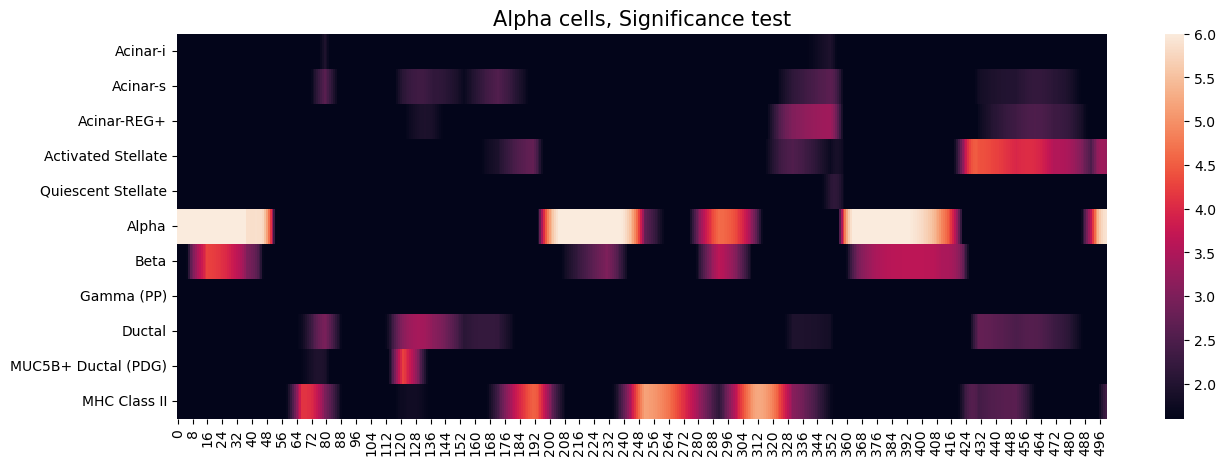

In [179]:
# single cell type

plt.figure(figsize = (15,5))
sns.heatmap(-np.log10(significance_test_less[5,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6)
plt.title("Alpha cells, Significance test")


In [ ]:
total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 15), gridspec_kw={'hspace': 0.25})

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

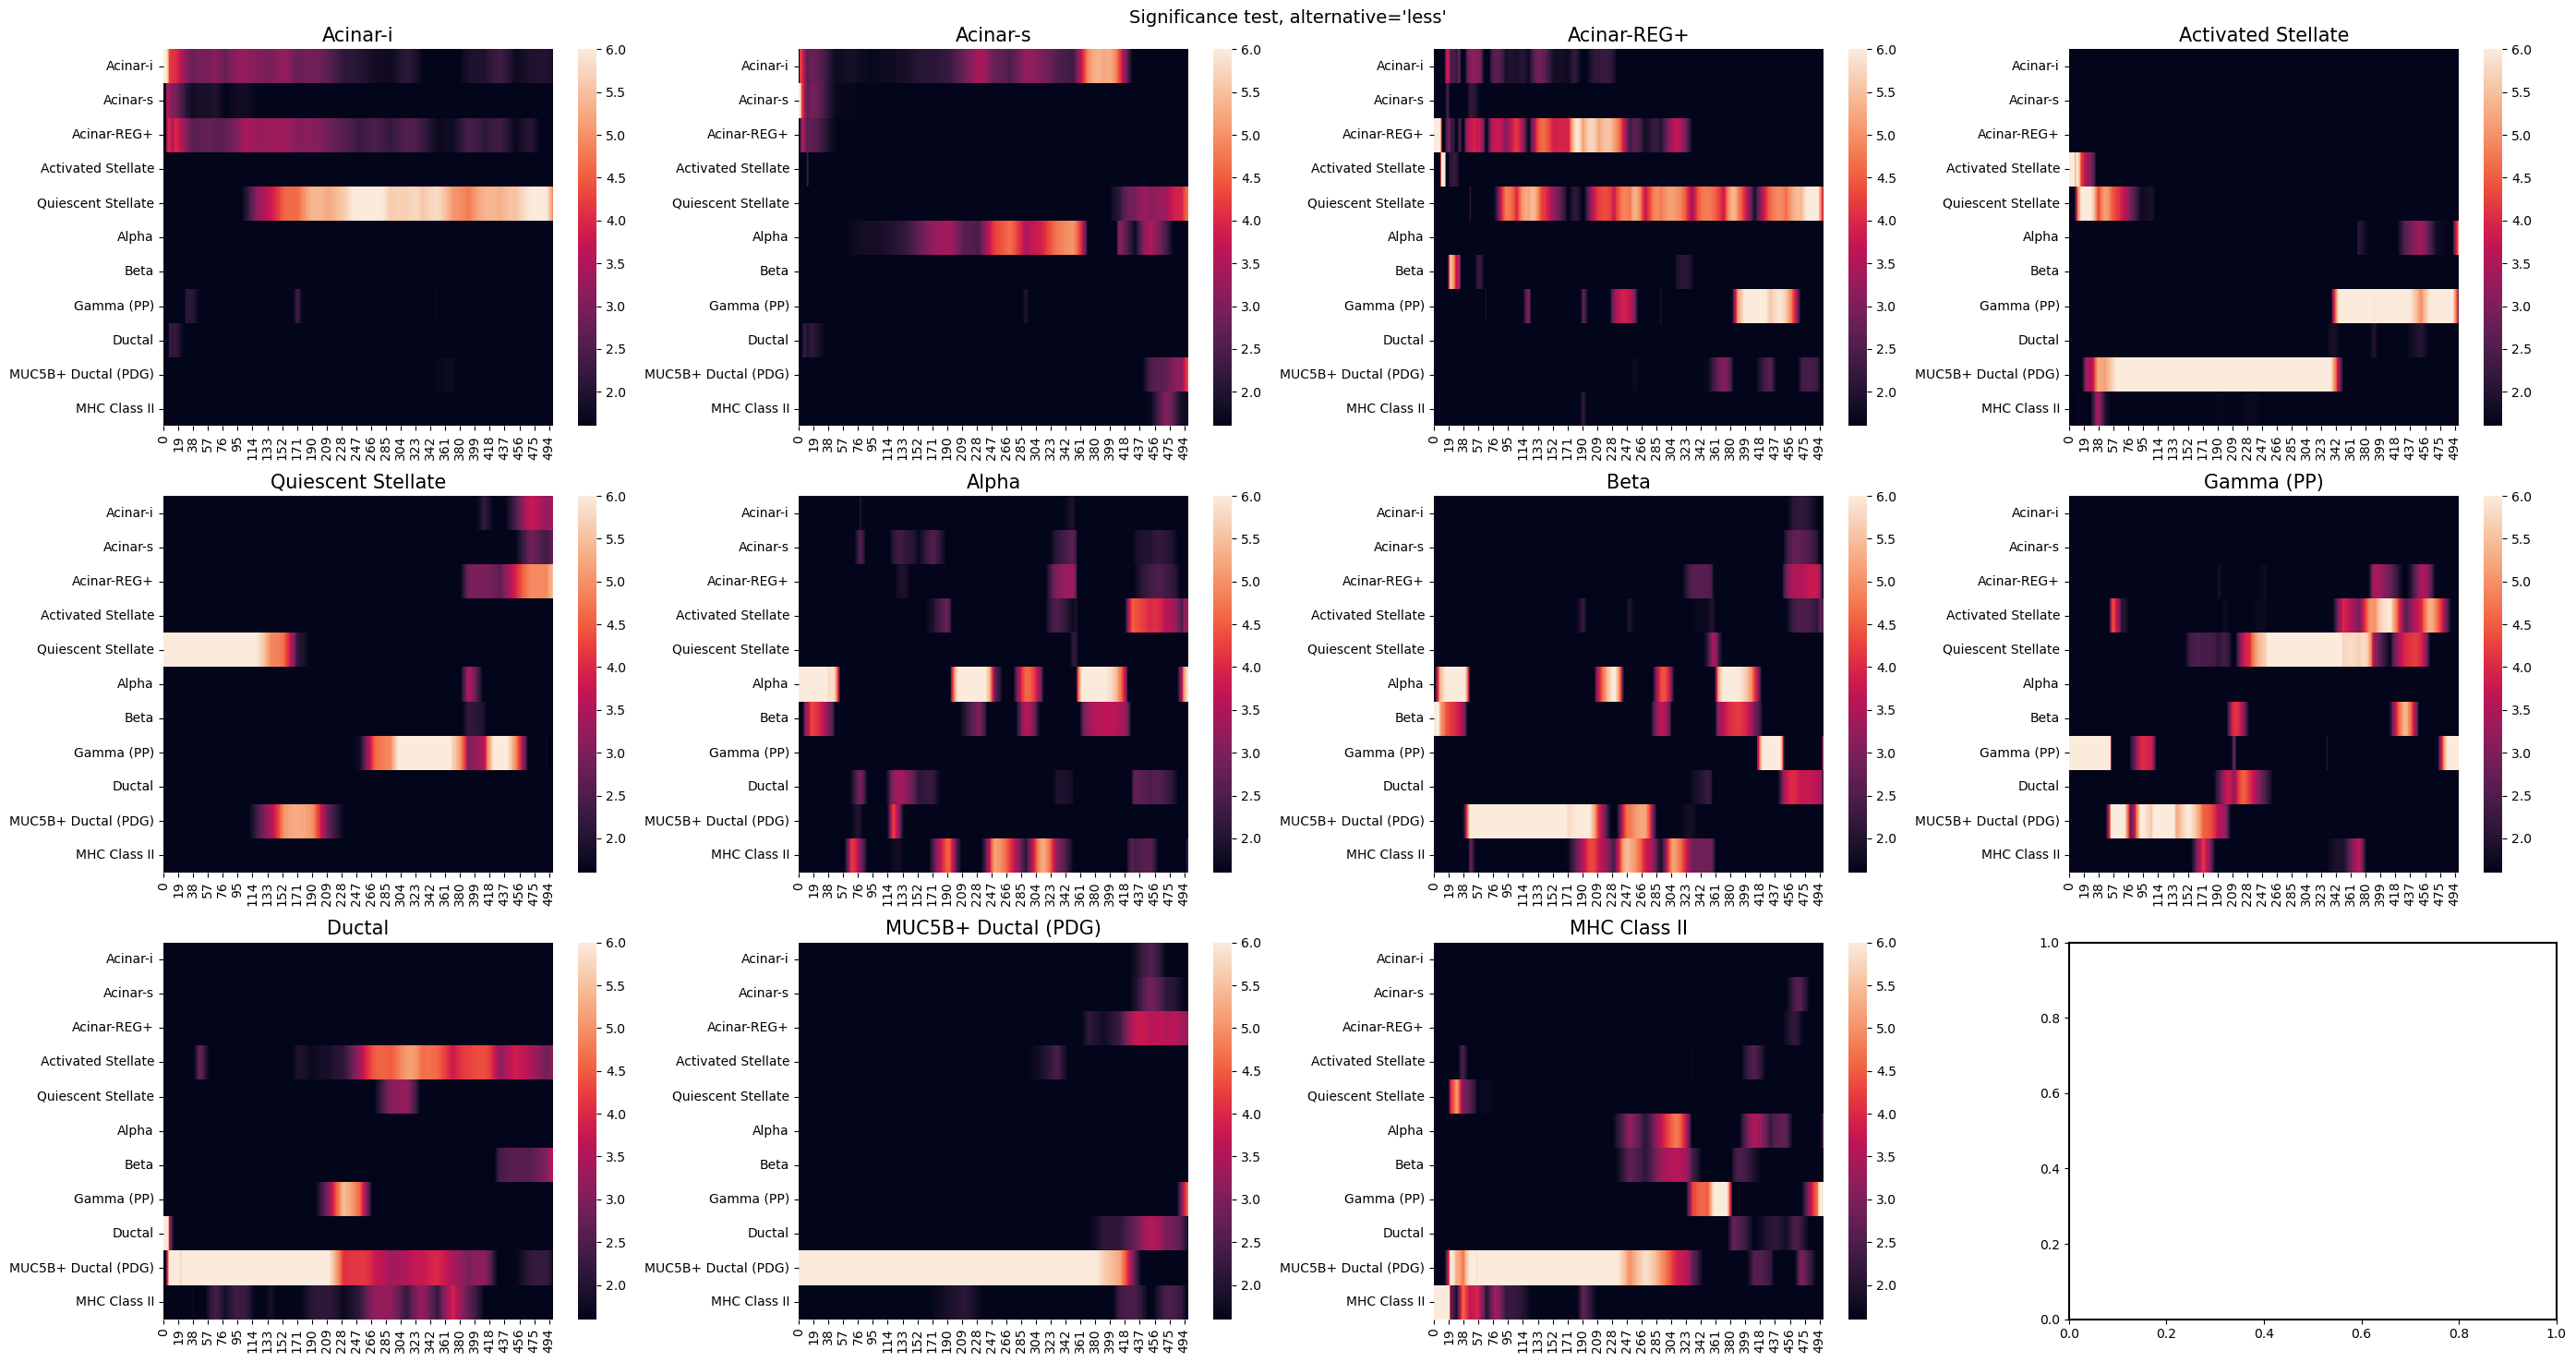

In [183]:
# alternative='less'

total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (28,15))

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

    sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax)
    ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}")

plt.suptitle("Significance test, alternative='less'", fontsize = 14)
plt.tight_layout()
plt.show()

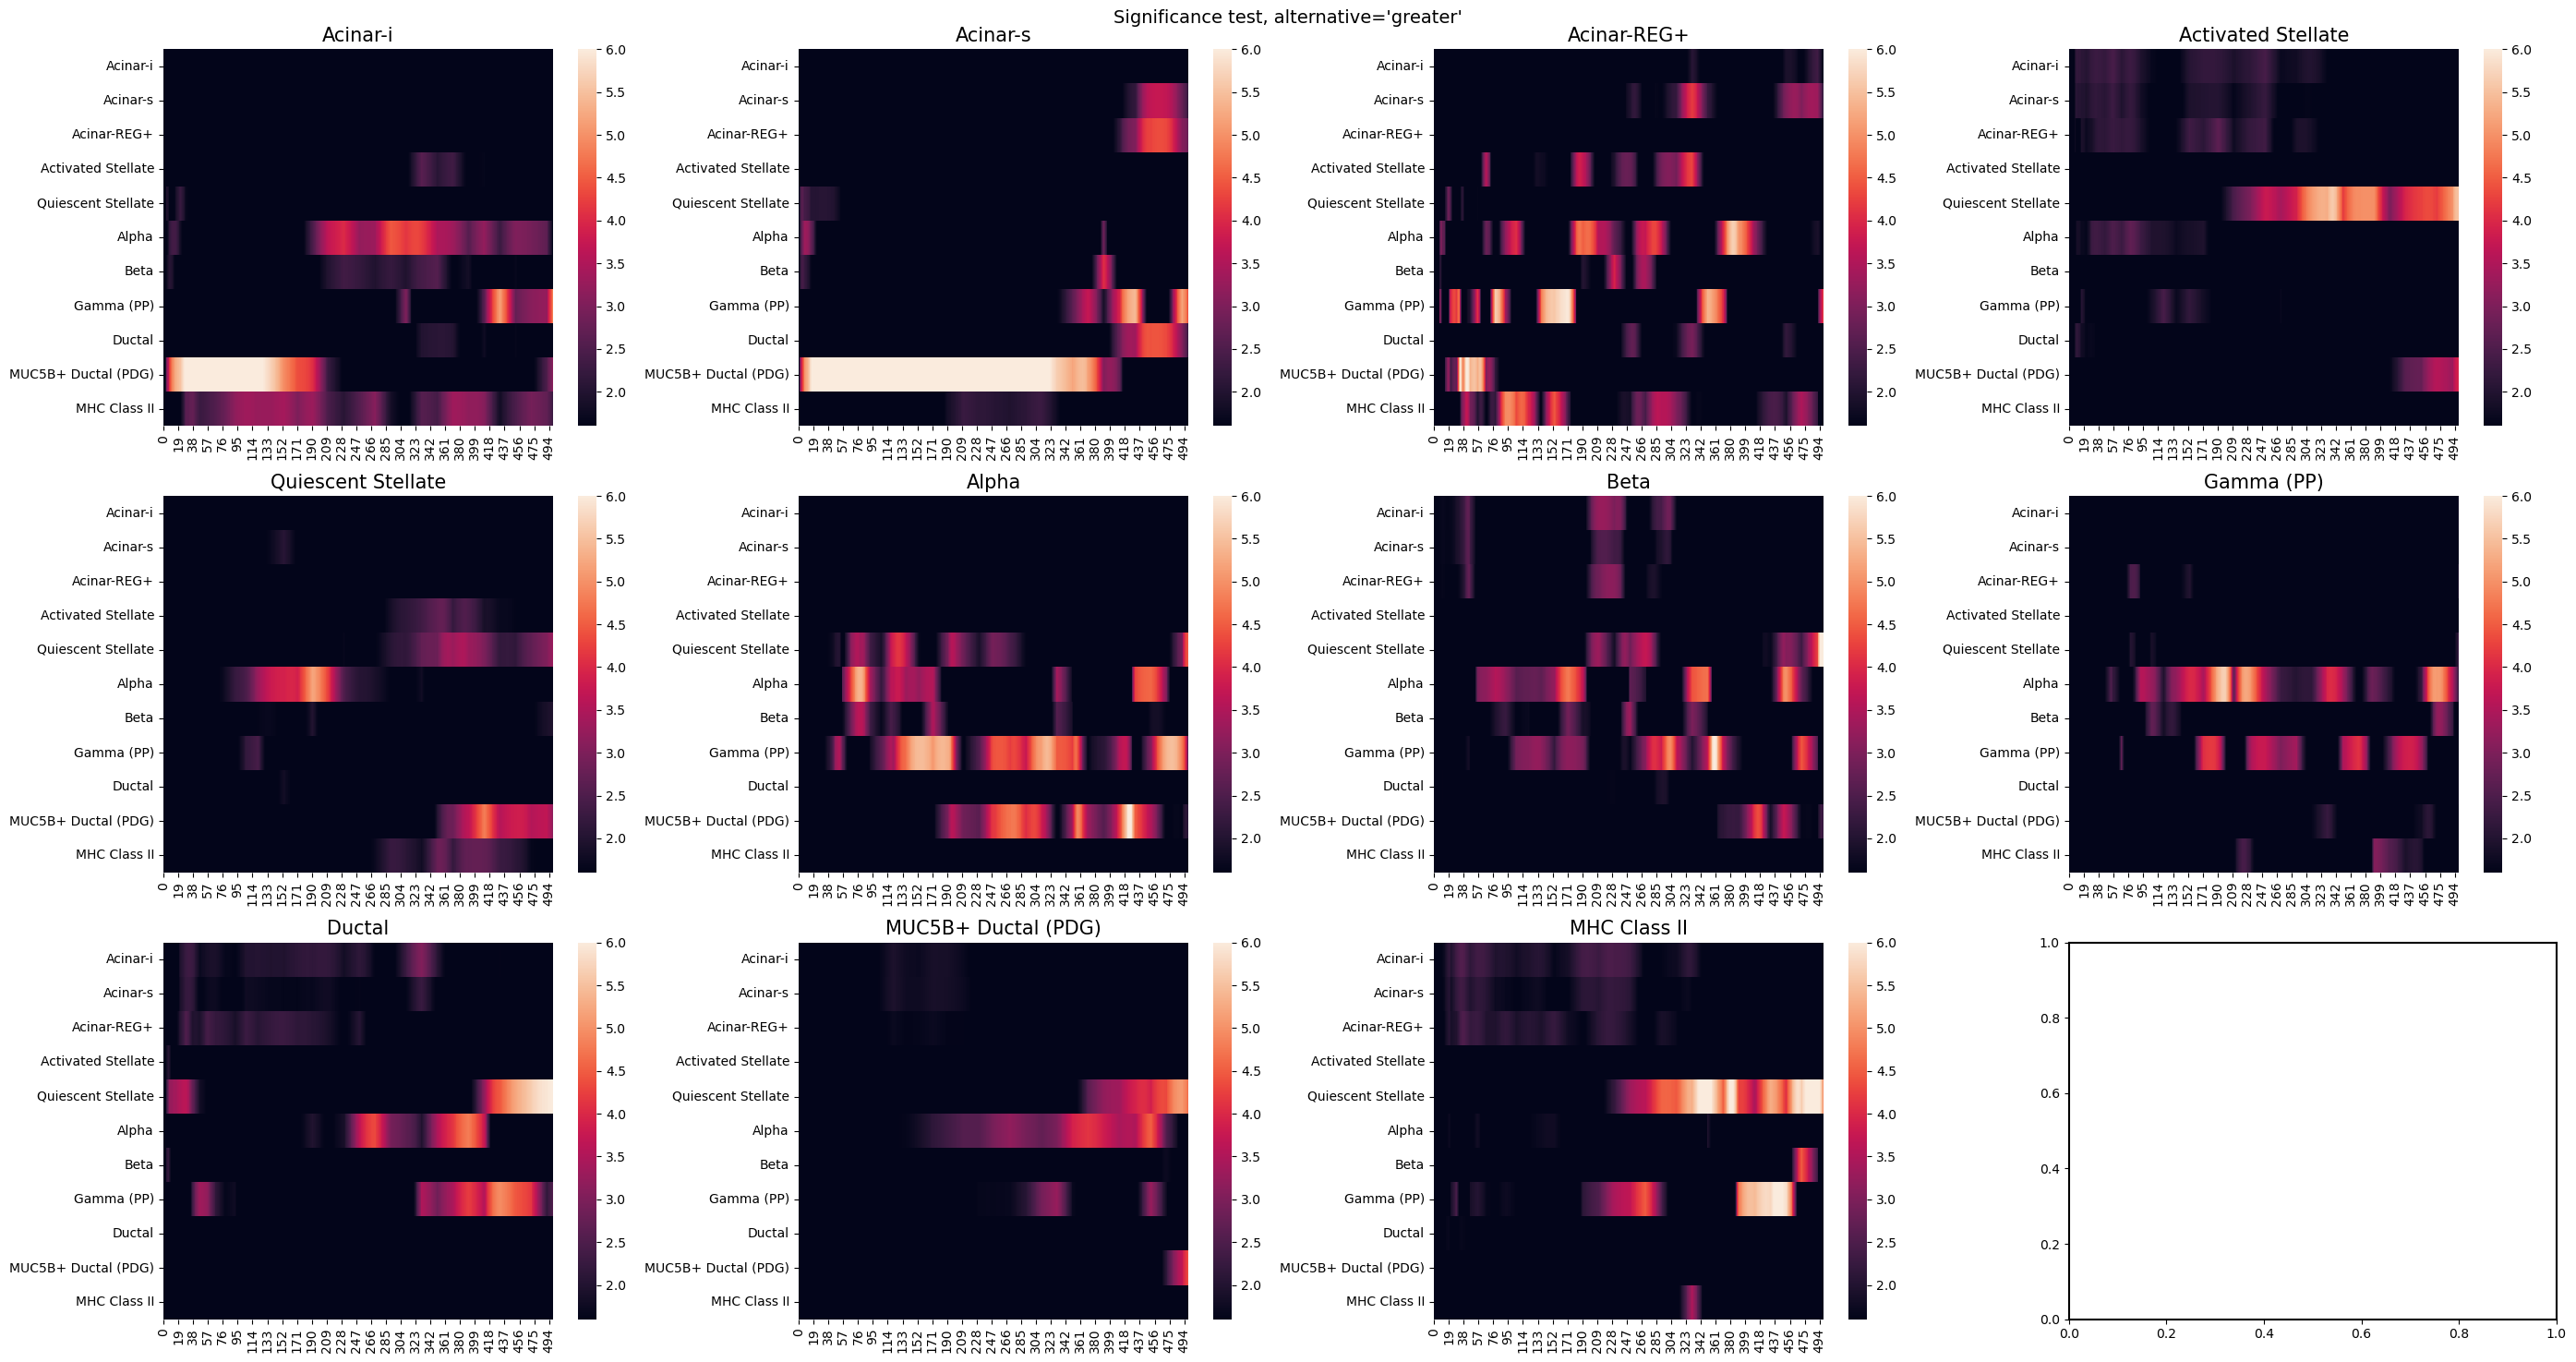

In [184]:
# alternative='greater'

total_plots = len(indices_above_threshold)  # Example total number of plots
n_cols = 4       # Fixed number of columns

# Calculate the number of rows needed
n_rows = math.ceil(total_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (28,15))

for ax_order, pivot_cell_type in enumerate(indices_above_threshold):  
    row = ax_order // n_cols
    col = ax_order % n_cols
    ax = axes[row, col]

    sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax)
    ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}")

plt.suptitle("Significance test, alternative='greater'", fontsize = 14)
plt.tight_layout()
plt.show()

## Different types of plots together for comparison

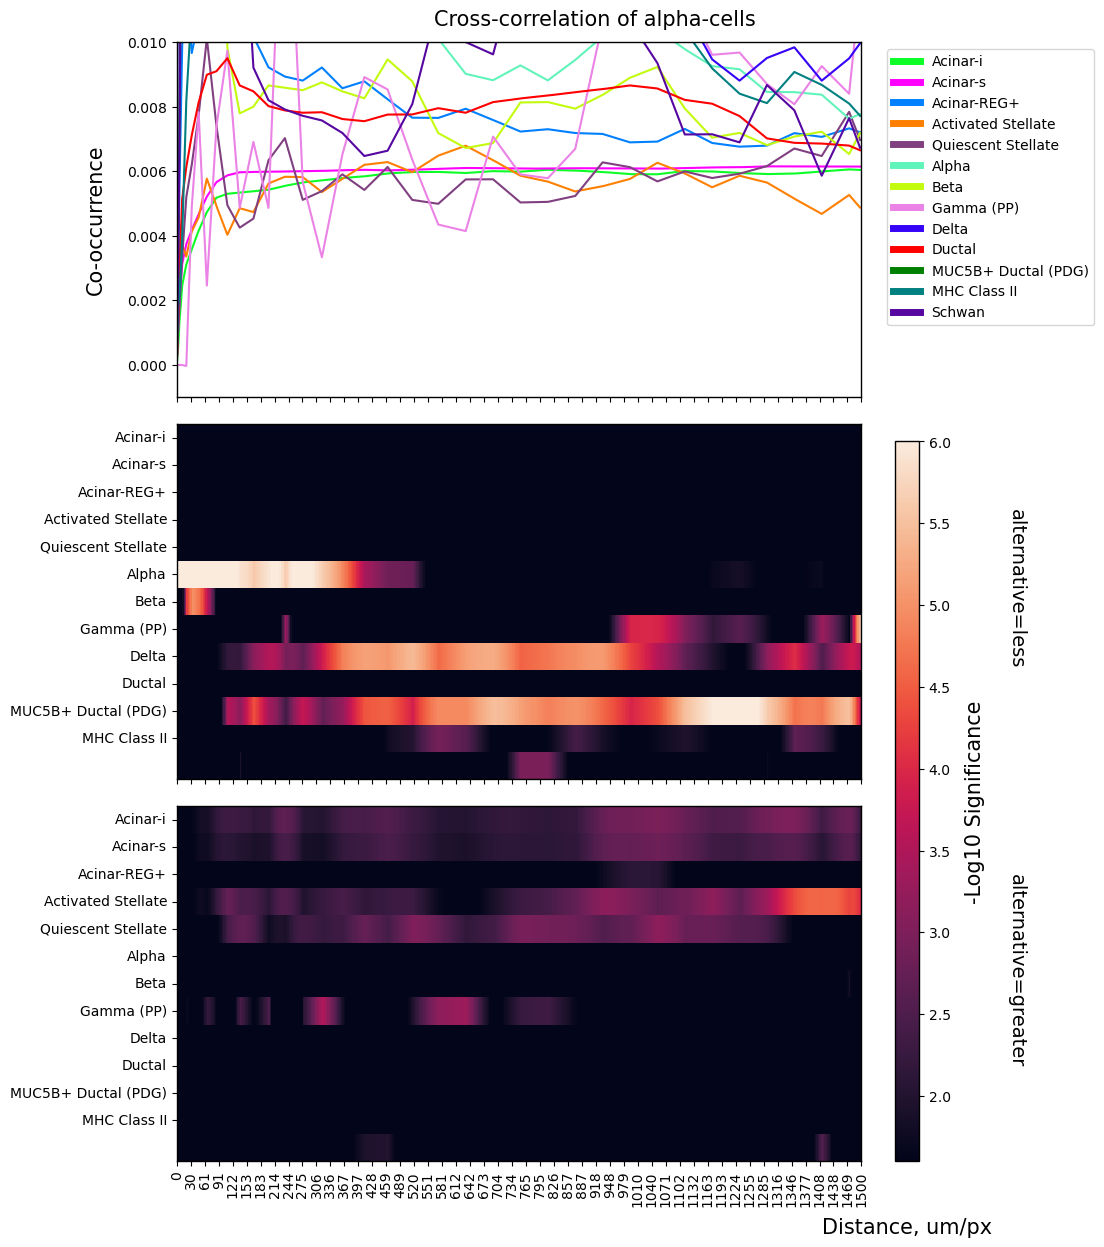

In [318]:
fig, axes = plt.subplots(3,1, figsize = (12,12), sharex=True)
pivot_cell_type = 5


ax_curves = axes[0]
for target_cell_type in range(normalized_coocur.shape[1]):
    ax_curves.plot(normalized_coocur[5,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
    ax_curves.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
    ax_curves.set_ylim(-0.001, 0.01)
ax_curves.set_ylabel('Co-occurrence', labelpad=15)


ax_less = axes[1]
sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_less, cbar=False)
# Adjust the frame of the heatmap
ax_less.spines['top'].set_visible(True)
ax_less.spines['right'].set_visible(True)
ax_less.spines['bottom'].set_visible(True)
ax_less.spines['left'].set_visible(True)


ax_great = axes[2]
sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_great, cbar=False)


# Adjust the frame of the heatmap
ax_great.spines['top'].set_visible(True)
ax_great.spines['right'].set_visible(True)
ax_great.spines['bottom'].set_visible(True)
ax_great.spines['left'].set_visible(True)


# Adjust the frame of all plots
for ax in [ax_curves, ax_less, ax_great]:
    ax.spines['top'].set_linewidth(1) 
    ax.spines['right'].set_linewidth(1) 
    ax.spines['bottom'].set_linewidth(1)  # Adjust linewidth as needed
    ax.spines['left'].set_linewidth(1)

# Customize x-axis ticks
xlox = np.linspace(0,500,50)
xtix = [str(int(i)) for i in xlox*3] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
plt.xticks(xlox,xtix)    


plt.tight_layout()

# Create a color bar
cbar_ax = fig.add_axes([0.75, 0.05, 0.02, 0.6])  # Adjust the values as needed
cbar = plt.colorbar(ax_less.collections[0], cax=cbar_ax)
cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
cbar.outline.set_linewidth(1)

# Adjust the linewidth of legend lines
legend_lines = ax_curves.get_legend().get_lines()
for line in legend_lines:
    line.set_linewidth(5.0)


# Add a text annotation on the right side of an alternative=less plot
ax_less.annotate("alternative=less", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)

# Add a text annotation on the right side of an alternative=greater plot
ax_great.annotate("alternative=greater", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)


plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
plt.suptitle("Cross-correlation of alpha-cells", fontsize=15, y=1.01)
plt.show()

In [185]:
from matplotlib.backends.backend_pdf import PdfPages

In [186]:
from datetime import datetime

current_datetime = datetime.now()

# Format the date and time
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")

print(formatted_datetime)

2023_08_24_14_54_38


In [188]:
pdf_filename = "pancreas_sample1_" + formatted_datetime + ".pdf"
pdf_filename

'pancreas_sample1_2023_08_24_14_54_38.pdf'

In [190]:
# Create a PDF file
pdf_filename = "pancreas_sample1_" + formatted_datetime + ".pdf"
pdf_pages = PdfPages(pdf_filename)

for figure in indices_above_threshold:

    # Initiating a figure
    fig, axes = plt.subplots(3,1, figsize = (12,12), sharex=True)

    pivot_cell_type = figure 

    # Sonar cross-correlation curves
    ax_curves = axes[0]
    for target_cell_type in indices_above_threshold:

        # y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2.5

        ax_curves.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
        ax_curves.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
        ax_curves.set_ylim(0,5)
    ax_curves.set_ylabel('Relative enrichment', labelpad=15)
        
    # Significance heatmap of one-sided t-test, alternative=less
    ax_less = axes[1]
    sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax_less, cbar=False)
    # ax_less.set_title("alternative=less")
    # Add a text annotation on the right side of an alternative=less plot
    ax_less.annotate("alternative=less", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)
    # Adjust the frame of the heatmap
    ax_less.spines['top'].set_visible(True)
    ax_less.spines['right'].set_visible(True)
    ax_less.spines['bottom'].set_visible(True)
    ax_less.spines['left'].set_visible(True)

    # Significance heatmap of one-sided t-test, alternative=greater
    ax_great = axes[2]
    sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,indices_above_threshold,:]), cmap="rocket", yticklabels = [relevant_cluster_labels[i] for i in indices_above_threshold], vmin = 1.6, vmax=6, ax=ax_great, cbar=False)
    # ax_great.set_title("alternative=greater")
    # Add a text annotation on the right side of an alternative=greater plot
    ax_great.annotate("alternative=greater", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)
    # Adjust the frame of the heatmap
    ax_great.spines['top'].set_visible(True)
    ax_great.spines['right'].set_visible(True)
    ax_great.spines['bottom'].set_visible(True)
    ax_great.spines['left'].set_visible(True)

    for ax in [ax_curves, ax_less, ax_great]:
        ax.spines['top'].set_linewidth(1) 
        ax.spines['right'].set_linewidth(1) 
        ax.spines['bottom'].set_linewidth(1)  # Adjust linewidth as needed
        ax.spines['left'].set_linewidth(1)

    
    # Customize x-axis ticks
    xlox = np.linspace(0,500,50)
    xtix = [str(int(i)) for i in xlox*3] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
    plt.xticks(xlox,xtix)   

    plt.tight_layout()

    # Create a color bar
    cbar_ax = fig.add_axes([0.75, 0.05, 0.02, 0.6])  # Adjust the values as needed
    cbar = plt.colorbar(ax_less.collections[0], cax=cbar_ax)
    cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
    cbar.outline.set_linewidth(1)

    # Adjust the linewidth of legend lines
    legend_lines = ax_curves.get_legend().get_lines()
    for line in legend_lines:
        line.set_linewidth(5.0)

    plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
    plt.suptitle(f"Cross-correlation of {relevant_cluster_labels[figure]}", fontsize=15, y=1.01)

    # Save the current figure to the PDF file
    pdf_pages.savefig()

    # Close the current figure
    plt.close()

# Close the PDF file
pdf_pages.close()

plt.show()